In [1]:
import pandas as pd

In [2]:
import argparse
import os
import sys
sys.path.append("..")
from util.formatting.convert_order_stream import dir_path
from order_flow_stylized_facts import unpickle_stream_dfs_to_stream_list, YEAR_OFFSET
import pickle
from realism_utils import get_plot_colors
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from util.util import OrderSizeDistribution

class Constants:
    """ Stores constants for use in plotting code. """

    # Plot params -- Generic
    fig_height = 10
    fig_width = 15
    tick_label_size = 20
    legend_font_size = 20
    axes_label_font_size = 20
    title_font_size = 22
    scatter_marker_styles_sizes = [('x', 60), ('+', 60), ('o', 14), (',', 60)]
    
    # Generalised Mixture model fit params
    norm_spike_sigma = 0.15
    log_norm_initial_weight = 0.5
    EM_inertia = 0.5
    num_norm_spikes = 10
    log_mu = 4
    log_sigma = 1.38
    
    # Plot params -- Limit Order size
    limit_order_sizes_xlabel = "Limit Order Size"
    limit_order_sizes_ylabel = "Empirical density"
    limit_order_sizes_filename = "limit_order_sizes"
    limit_order_size_fit_lower_bound = 0
    limit_order_size_fit_upper_bound = 10
    limit_order_size_hist_linewidth = 3
    limit_order_size_fit_linewidth = 2


def bundled_stream_limit_order_sizes(bundled_streams):
    """ From bundled streams return dict with limit order sizes collated by symbol. """

    limit_order_sizes_dict = dict()

    for idx, elem in enumerate(bundled_streams):
        print(f"Processing elem {idx + 1} of {len(bundled_streams)}")
        orders_df = elem["orders_df"]
        symbol = elem["symbol"]
        limit_orders = orders_df[orders_df['TYPE'] == "LIMIT_ORDER"]["SIZE"]

        if symbol not in limit_order_sizes_dict.keys():
            limit_order_sizes_dict[symbol] = limit_orders
        else:
            limit_order_sizes_dict[symbol] = limit_order_sizes_dict[symbol].append(limit_orders)

    return limit_order_sizes_dict



def set_up_plotting():
    """ Sets matplotlib variables for plotting. """
    plt.rc('xtick', labelsize=Constants.tick_label_size)
    plt.rc('ytick', labelsize=Constants.tick_label_size)
    plt.rc('legend', fontsize=Constants.legend_font_size)
    plt.rc('axes', labelsize=Constants.axes_label_font_size)



In [3]:
bundled_orders_dict = unpickle_stream_dfs_to_stream_list('../../abides-marketreplay-fast/marketreplay_streams/PG/')


Processing ../../abides-marketreplay-fast/marketreplay_streams/PG/orders_PG_20190605.pkl
Processing ../../abides-marketreplay-fast/marketreplay_streams/PG/orders_PG_20190614.pkl
Processing ../../abides-marketreplay-fast/marketreplay_streams/PG/orders_PG_20190627.pkl
Processing ../../abides-marketreplay-fast/marketreplay_streams/PG/orders_PG_20190618.pkl
Processing ../../abides-marketreplay-fast/marketreplay_streams/PG/orders_PG_20190610.pkl
Processing ../../abides-marketreplay-fast/marketreplay_streams/PG/orders_PG_20190625.pkl
Processing ../../abides-marketreplay-fast/marketreplay_streams/PG/orders_PG_20190607.pkl
Processing ../../abides-marketreplay-fast/marketreplay_streams/PG/orders_PG_20190612.pkl
Processing ../../abides-marketreplay-fast/marketreplay_streams/PG/orders_PG_20190603.pkl
Processing ../../abides-marketreplay-fast/marketreplay_streams/PG/orders_PG_20190621.pkl
Processing ../../abides-marketreplay-fast/marketreplay_streams/PG/orders_PG_20190624.pkl
Processing ../../abid

In [4]:
bundled_limit_order_sizes_dict = bundled_stream_limit_order_sizes(bundled_orders_dict)


Processing elem 1 of 20
Processing elem 2 of 20
Processing elem 3 of 20
Processing elem 4 of 20
Processing elem 5 of 20
Processing elem 6 of 20
Processing elem 7 of 20
Processing elem 8 of 20
Processing elem 9 of 20
Processing elem 10 of 20
Processing elem 11 of 20
Processing elem 12 of 20
Processing elem 13 of 20
Processing elem 14 of 20
Processing elem 15 of 20
Processing elem 16 of 20
Processing elem 17 of 20
Processing elem 18 of 20
Processing elem 19 of 20
Processing elem 20 of 20


In [5]:
from pomegranate import LogNormalDistribution, NormalDistribution, GeneralMixtureModel

In [6]:
def fit_pomegranate_model(x, num_spikes, log_mu, log_sigma):
    """
        TODO: save json model
    """
    mixture_components = [LogNormalDistribution(log_mu, log_sigma)]
    for n in range(1, num_spikes + 1):
        dist = NormalDistribution(100*n, Constants.norm_spike_sigma, frozen=True)
        mixture_components.append(dist)
    
    log_norm_weight = Constants.log_norm_initial_weight
    model_weights = np.array([log_norm_weight] + [ log_norm_weight / num_spikes for _ in range(num_spikes) ])
    model = GeneralMixtureModel(mixture_components, weights=model_weights)
    X = np.array(x).reshape((x.size, 1))
    
    model.fit(X,
             inertia=Constants.EM_inertia,
             verbose=True,
             n_jobs=-1)
    print(model.to_json())
    return model

In [7]:
def normalise_pdf(p, x):
    """
        For plotting, takes pdf p evaluated at points x and divides by binwidth for visual aid against histograms
        
    """
    bins = np.diff(x)
    normalising_constant = np.sum(np.multiply(p[1:], bins))
    return np.true_divide(p, normalising_constant)
    

In [8]:
def make_plot_x_axis(xlim):
    xx = np.logspace(np.log10(xlim[0]), np.log10(xlim[1]), 500)
    hundreds = np.array([n * 100 for n in range(1, 25)])
    xx = np.concatenate((xx, hundreds))
    return np.sort(xx)

In [9]:

def plot_limit_order_sizes(limit_order_sizes_dict, output_dir, scale='log'):
    """ Plots histogram of the limit order sizes for symbols. """

    fig, ax = plt.subplots(figsize=(Constants.fig_width, Constants.fig_height))

    if scale == 'log':
        ax.set(xscale="log", yscale="log")

    ax.set_ylabel(Constants.limit_order_sizes_ylabel)
    ax.set_xlabel(Constants.limit_order_sizes_xlabel)

    symbols = list(limit_order_sizes_dict.keys())
    symbols.sort()
    colors = get_plot_colors(symbols)
    alphas = [1] * len(symbols)

    x_s = []

    for symbol, color, alpha in zip(symbols, colors, alphas):
        limit_order_sizes_series = limit_order_sizes_dict[symbol]
        x = limit_order_sizes_series.sort_values(ascending=True)
        x_s.append(x)
        plt.hist(x, bins="sqrt", density=True, label=symbol, color=color, alpha=alpha, histtype="step",
                 linewidth=Constants.limit_order_size_hist_linewidth)

    ylim = ax.get_ylim()
    xlim = ax.get_xlim()

    xx = make_plot_x_axis(xlim)

    # # Plot fitted curves, leave out zeroes for better fit
    for x, symbol, color in zip(x_s, symbols, colors):
        x_left = xx[xx < x.min()][1:]
        x_mid = x.to_numpy()
        x_right = xx[xx > x.max()]
        xxx = np.concatenate((x_left, x_mid, x_right))
        model = fit_pomegranate_model(x, Constants.num_norm_spikes, Constants.log_mu, Constants.log_sigma)
        normed = normalise_pdf(model.probability(xx), xx)
        plt.plot(xx, normed, linestyle="-.", color=color,
                 label=f"{symbol} GMM fit", linewidth=Constants.limit_order_size_fit_linewidth)
    plt.legend(fontsize=Constants.legend_font_size)
    ax.set_ylim(ylim)
    
    plt.show()
#     fig.savefig(f'{output_dir}/{Constants.limit_order_sizes_filename}.png', format='png', dpi=300,
#                 transparent=False, bbox_inches='tight', pad_inches=0.03)
    return model

[1] Improvement: 7957881.876373212	Time (s): 2.277
[2] Improvement: 31086.70819932432	Time (s): 2.283
[3] Improvement: 8318.342642743606	Time (s): 2.281
[4] Improvement: 2200.134518208448	Time (s): 2.278
[5] Improvement: 567.4261086252518	Time (s): 2.281
[6] Improvement: 144.45028248568997	Time (s): 2.279
[7] Improvement: 36.5299481167458	Time (s): 2.277
[8] Improvement: 9.207064865157008	Time (s): 2.278
[9] Improvement: 2.3168787218164653	Time (s): 2.281
[10] Improvement: 0.5822828831151128	Time (s): 2.279
[11] Improvement: 0.14624940883368254	Time (s): 2.282
[12] Improvement: 0.037002772092819214	Time (s): 2.28
Total Improvement: 8000247.757551367
Total Time (s): 29.7501
{
    "class" : "GeneralMixtureModel",
    "distributions" : [
        {
            "class" : "Distribution",
            "name" : "LogNormalDistribution",
            "parameters" : [
                3.029373211791014,
                1.1885923314601254
            ],
            "frozen" : false
        },
       

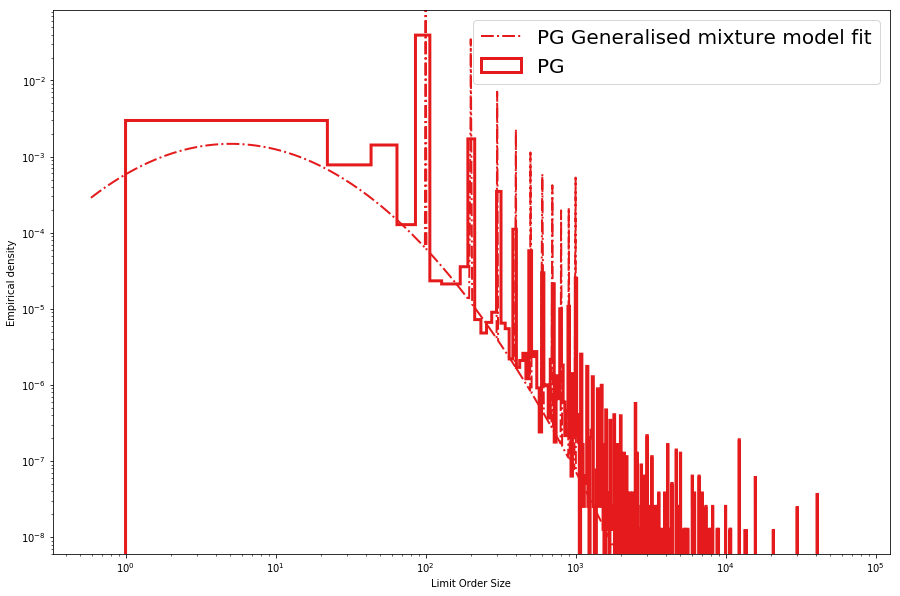

In [10]:
model = plot_limit_order_sizes(bundled_limit_order_sizes_dict, _)

In [11]:
model.probability([1.00782502e+02, 100])

array([1.66867400e-04, 2.21472161e+00])

In [12]:
pd.set_option('display.max_rows', 100)

In [13]:
bundled_limit_order_sizes_dict["PG"].value_counts(sort=False, ascending=True).iloc[90:110]

85         519
86         325
87         409
88         278
89         438
90        1532
91         376
92         380
93         376
94         259
95         543
96         323
97         345
98         445
99         514
100    3101656
101        168
102        197
103        122
104         57
Name: SIZE, dtype: int64

In [14]:
bundled_limit_order_sizes_dict["PG"].value_counts().index.to_numpy()

array([  100,   200,    10,    14,   300,     1,    18,    54,    53,
          56,    55,    30,    17,     5,    57,   400,    52,     2,
          38,    19,    50,    29,    45,    31,   500,    15,    51,
          58,    13,    12,     3,    44,    20,    46,    25,    35,
          33,    11,   199,     4,    36,    59,    47,    40,    48,
          60,    32,     7,   600,    34,     9,     6,  1000,     8,
          39,    16,    37,    24,   700,    42,    90,    22,    28,
          41,    49,    26,    21,    27,    43,    70,    23,    80,
          65,    75,   900,   800,    67,    95,    85,    99,    64,
          69,    98,    68,    89,   150,    87,    71,    76,    63,
          66,    92,    72,    91,    93,    82,    73,    97,    61,
          86,    96,   190,    84,    83,    62,    88,   335,    79,
          74,    94,    78,    77,   175,    81,   191,   102,   180,
         114,   176,  1100,   109,   108,   101,   290,   130,   110,
         181,   179,

In [15]:
bundled_limit_order_sizes_dict["PG"].value_counts().to_numpy()

array([3101656,  130637,   87297,   37662,   26671,   22672,   18226,
         16696,   15028,   13916,   13561,   13108,   11097,    9361,
          8769,    8567,    7651,    6588,    6306,    6024,    5331,
          5122,    4901,    4292,    4248,    4230,    3740,    3635,
          3621,    3552,    3525,    3454,    3206,    3187,    3174,
          3021,    2906,    2858,    2600,    2455,    2350,    2325,
          2292,    2286,    2254,    2232,    2230,    2218,    2215,
          2173,    2114,    2012,    1986,    1820,    1769,    1704,
          1650,    1593,    1577,    1536,    1532,    1515,    1513,
          1442,    1391,    1358,    1246,    1218,    1211,    1165,
          1053,     954,     895,     864,     798,     737,     588,
           543,     519,     514,     477,     458,     445,     443,
           438,     437,     409,     401,     398,     396,     394,
           380,     377,     376,     376,     367,     349,     345,
           327,     

In [19]:
pd.Series(np.round(model.sample(30000))).value_counts()

100.0    25003
200.0     1025
300.0      196
7.0        139
3.0        120
         ...  
426.0        1
298.0        1
251.0        1
217.0        1
341.0        1
Length: 281, dtype: int64